**Install Keras Tuner**

In [1]:
!pip install -q -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.1 MB/s eta 0:00:00


# EfficientNetB3

In [2]:
# 1. 📦 Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 2. 🧪 Load dataset from directory (adjust path as needed)
data_dir = '/content/drive/MyDrive/archive/dataset'

filepaths, labels = [], []
for label in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, label)):
        filepaths.append(os.path.join(data_dir, label, img))
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df['labels'].value_counts()


,count
labels,
diabetic_retinopathy,1098
normal,1074
cataract,1038
glaucoma,1017
train,4
test,4


In [5]:
# 3. 📤 Train/Validation/Test split
from sklearn.model_selection import train_test_split

# Remove 'train' and 'test' labels as they have very few samples
df_filtered = df[~df['labels'].isin(['train', 'test'])].copy()

train_df, dummy_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['labels'], random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, stratify=dummy_df['labels'], random_state=42)

print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3381, 2)
Validation DataFrame shape: (423, 2)
Test DataFrame shape: (423, 2)


In [6]:
# 4. 🌀 Data Generators
IMG_SIZE = (300, 300)
BATCH_SIZE = 16
tr_gen_new = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7, 1.3),
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen_new = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)


Found 3381 validated image filenames belonging to 4 classes.
Found 423 validated image filenames belonging to 4 classes.
Found 423 validated image filenames belonging to 4 classes.


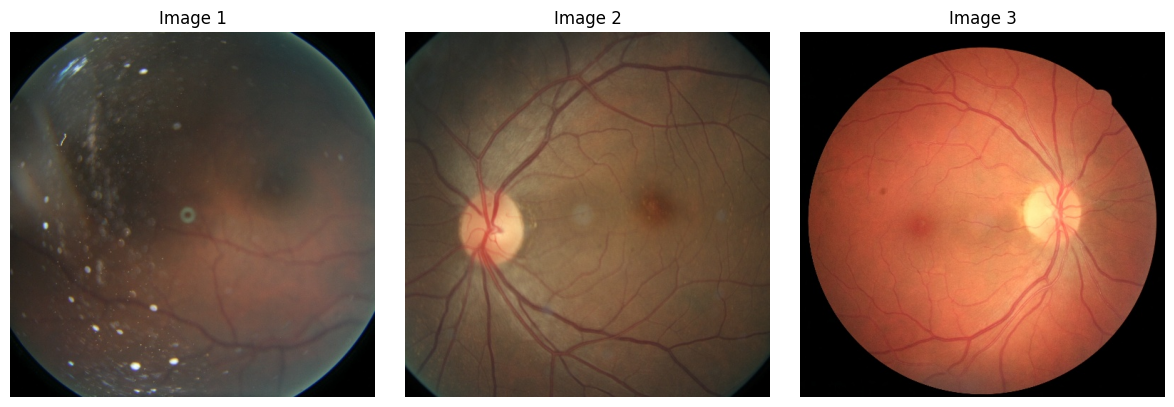

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image dataset folder
dataset_path = '/content/drive/MyDrive/archive/dataset'

# Walk through subfolders to find JPEG images
jpeg_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith('.jpeg'):
            jpeg_images.append(os.path.join(root, file))
        if len(jpeg_images) >= 3:
            break
    if len(jpeg_images) >= 3:
        break

# Display the first 3 .jpeg images
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(jpeg_images):
    img = Image.open(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# 5. 🔧 Define EfficientNetB3 model builder for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
    base_model.trainable = True

    fine_tune_at = hp.Choice('fine_tune_at', [425, 445])
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', 128, 256, step=64), activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
# 6. 🔎 Run hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='efficientnet_tuning',
    project_name='eye_disease_efficientnet'
)

tuner.search(train_gen, validation_data=valid_gen, epochs=5)


Trial 5 Complete [00h 04m 33s]
val_accuracy: 0.86052006483078

Best val_accuracy So Far: 0.8794326186180115
Total elapsed time: 01h 02m 28s


In [10]:
# 7. ✅ Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optional: Fine-tune longer
history = best_model.fit(train_gen, validation_data=valid_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 104s 328ms/step - accuracy: 0.8496 - loss: 0.3877 - val_accuracy: 0.8865 - val_loss: 0.3707
Epoch 2/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.8564 - loss: 0.3565 - val_accuracy: 0.8794 - val_loss: 0.3513
Epoch 3/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8733 - loss: 0.3379 - val_accuracy: 0.8983 - val_loss: 0.3424
Epoch 4/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.8658 - loss: 0.3522 - val_accuracy: 0.8652 - val_loss: 0.3618
Epoch 5/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.8933 - loss: 0.3132 - val_accuracy: 0.8936 - val_loss: 0.3328


In [11]:
# 8. 📈 Evaluate on test data
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2%}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 233s 9s/step - accuracy: 0.8511 - loss: 0.3433
Test Accuracy: 86.05%


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 522ms/step
                      precision    recall  f1-score   support

            cataract       0.93      0.88      0.91       104
diabetic_retinopathy       0.98      0.95      0.97       110
            glaucoma       0.70      0.86      0.77       101
              normal       0.87      0.74      0.80       108

            accuracy                           0.86       423
           macro avg       0.87      0.86      0.86       423
        weighted avg       0.87      0.86      0.86       423



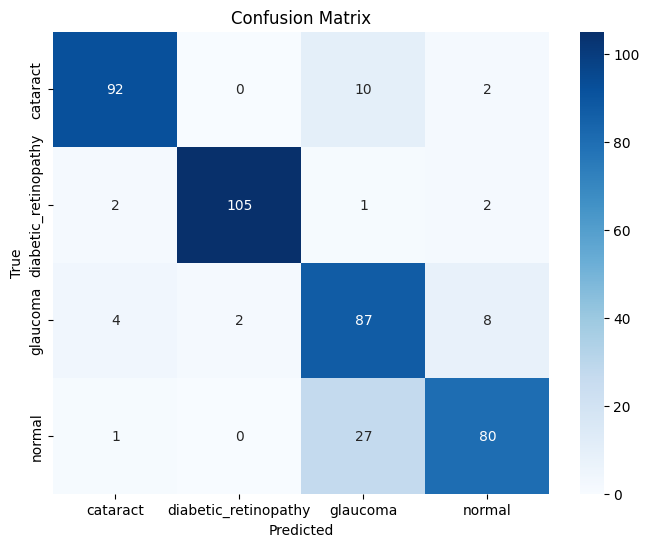

In [12]:
# 9. 📊 Classification Report + Confusion Matrix
y_true = test_gen.classes
y_pred = np.argmax(best_model.predict(test_gen), axis=1)
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


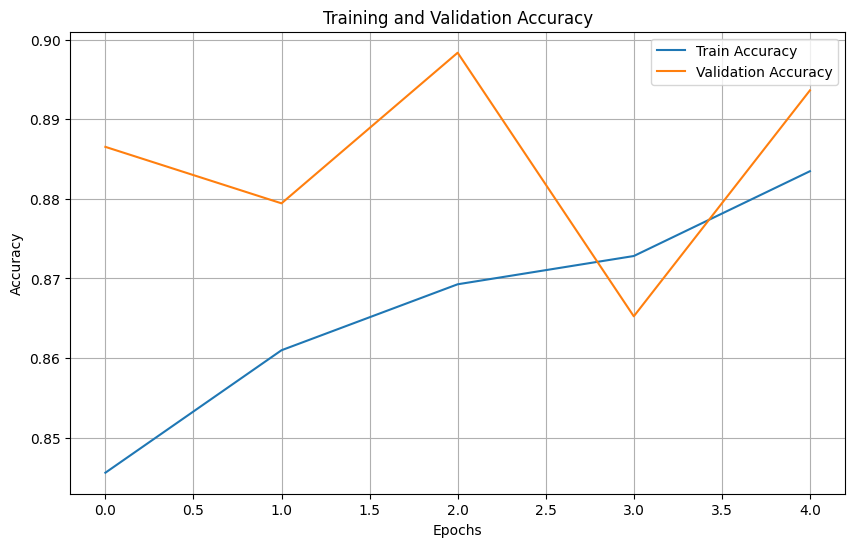

In [13]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

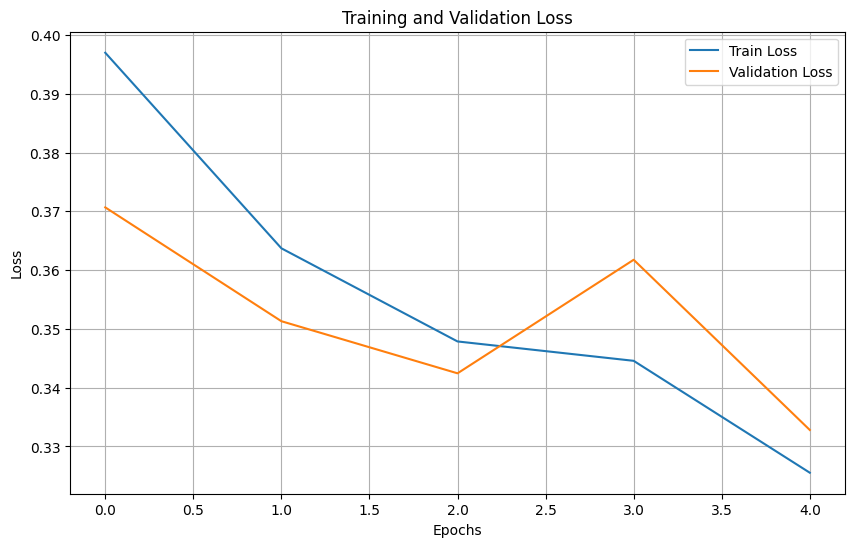

In [14]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step


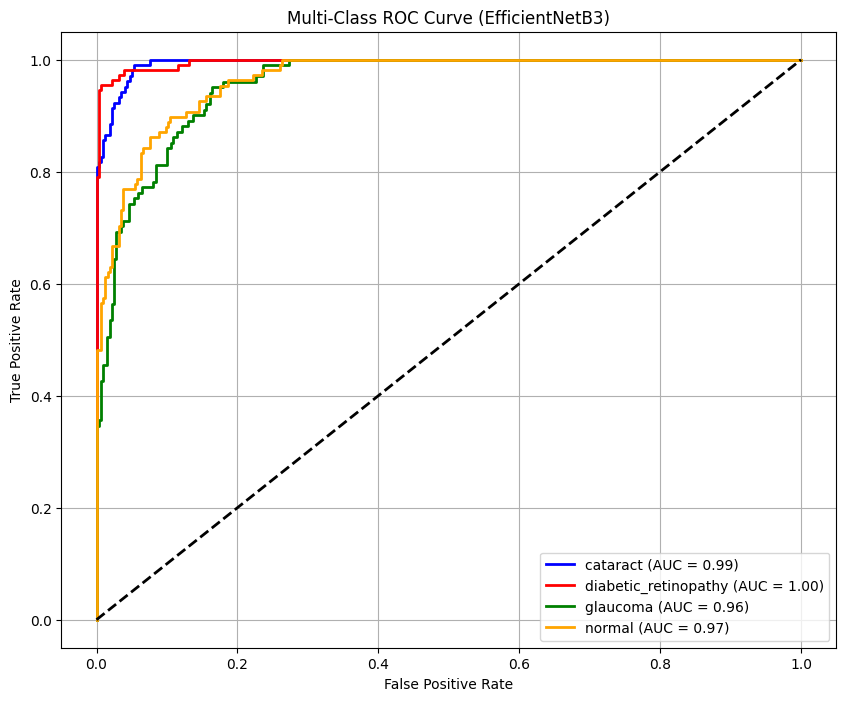

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Get class names
class_names = list(test_gen.class_indices.keys())
n_classes = len(class_names)

# True labels (integer format)
y_true = test_gen.classes

# One-hot encode true labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Predict probabilities
y_pred_probs = best_model.predict(test_gen)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (EfficientNetB3)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# VGG19

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt


In [ ]:
data_dir = '/content/drive/MyDrive/archive/dataset'

filepaths, labels = [], []
for label in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, label)):
        filepaths.append(os.path.join(data_dir, label, img))
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


In [ ]:
from sklearn.model_selection import train_test_split

# Remove 'train' and 'test' labels as they have very few samples
df_filtered = df[~df['labels'].isin(['train', 'test'])].copy()

train_df, dummy_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['labels'], random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, stratify=dummy_df['labels'], random_state=42)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7, 1.3),
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


In [ ]:
def build_vgg_model(hp):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = True

    # Unfreeze top N layers
    unfreeze = hp.Int('unfreeze_layers', 0, 5)
    for layer in base_model.layers[:-unfreeze]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1))(x)
    x = Dense(hp.Int('units', 128, 512, step=128), activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_vgg_model,
    objective='val_accuracy',
    max_trials=5,
    directory='vgg_tuning',
    project_name='eye_disease_vgg19'
)

tuner.search(train_gen, validation_data=valid_gen, epochs=5)


Trial 5 Complete [00h 04m 17s]
val_accuracy: 0.9028435945510864

Best val_accuracy So Far: 0.9028435945510864
Total elapsed time: 00h 20m 41s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(train_gen, validation_data=valid_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 407ms/step - accuracy: 0.9034 - loss: 0.2527 - val_accuracy: 0.8768 - val_loss: 0.2629
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.9278 - loss: 0.2048 - val_accuracy: 0.9028 - val_loss: 0.2372
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 393ms/step - accuracy: 0.9320 - loss: 0.1838 - val_accuracy: 0.9147 - val_loss: 0.2205
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 390ms/step - accuracy: 0.9475 - loss: 0.1388 - val_accuracy: 0.8934 - val_loss: 0.2506
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.9548 - loss: 0.1211 - val_accuracy: 0.9123 - val_loss: 0.2345


In [ ]:
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2%}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - accuracy: 0.8882 - loss: 0.2667
Test Accuracy: 90.52%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step
                      precision    recall  f1-score   support

            cataract       0.96      0.89      0.93       104
diabetic_retinopathy       0.99      1.00      1.00       110
            glaucoma       0.80      0.86      0.83       101
              normal       0.88      0.86      0.87       107

            accuracy                           0.91       422
           macro avg       0.91      0.90      0.90       422
        weighted avg       0.91      0.91      0.91       422



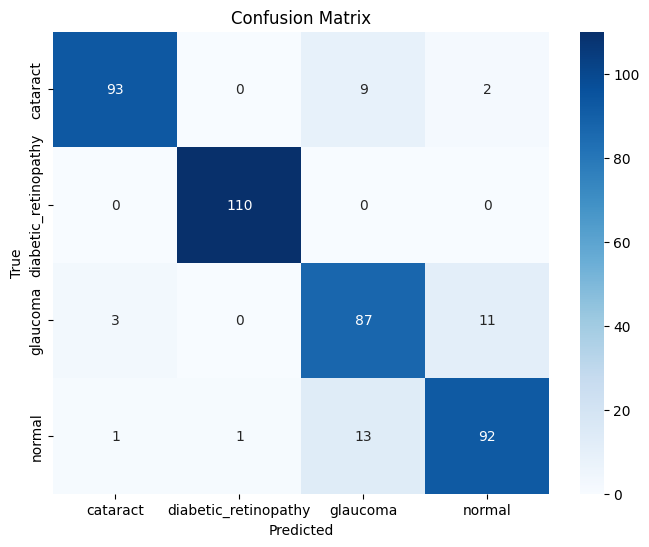

In [ ]:
y_true = test_gen.classes
y_pred = np.argmax(best_model.predict(test_gen), axis=1)
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


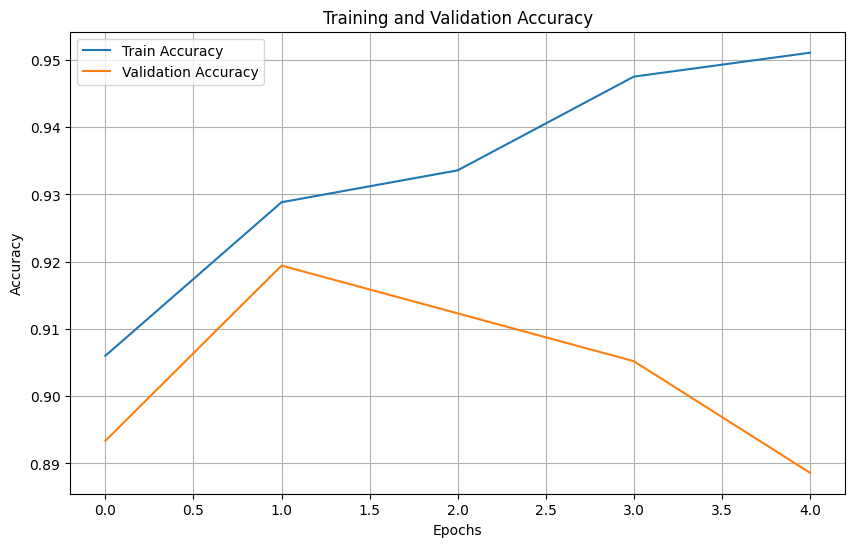

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

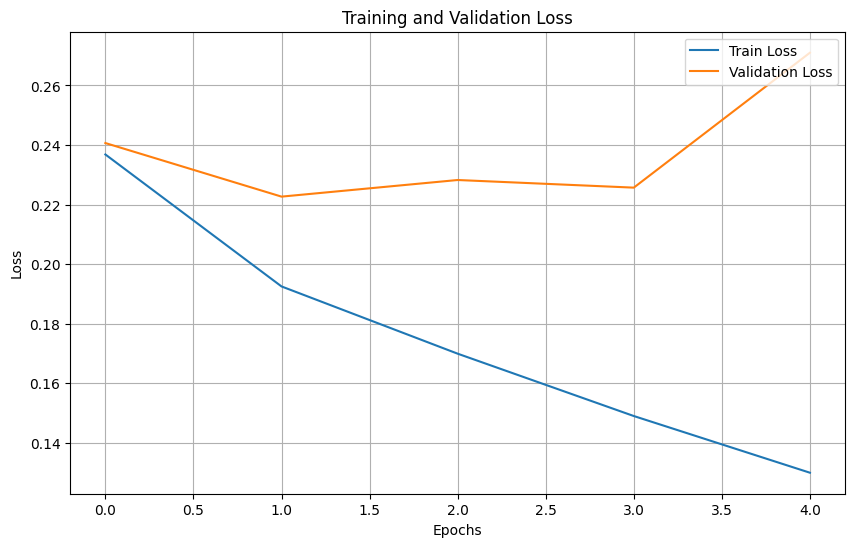

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## **InceptionV3 **

## **Import Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt


# Load data

In [ ]:
data_dir = '/content/drive/MyDrive/archive/dataset'

filepaths, labels = [], []
for label in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, label)):
        filepaths.append(os.path.join(data_dir, label, img))
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


# Split into train, validation, test

In [ ]:
from sklearn.model_selection import train_test_split

# Remove 'train' and 'test' labels as they have very few samples
df_filtered = df[~df['labels'].isin(['train', 'test'])].copy()

train_df, dummy_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['labels'], random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, stratify=dummy_df['labels'], random_state=42)

# Data Preprocessing

In [ ]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 16
tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7, 1.3),
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=True
)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

num_classes = len(train_gen.class_indices)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


# Model builder for Keras Tuner

In [ ]:
def build_inception_model(hp):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
    base_model.trainable = True

    # Fine-tune upper N layers only
    fine_tune_at = hp.Choice('fine_tune_at', [249, 279, 299])
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


#  Run the hyperparameter tuner

In [ ]:
tuner = kt.RandomSearch(
    build_inception_model,
    objective='val_accuracy',
    max_trials=5,
    directory='inception_tuning',
    project_name='eye_disease_inceptionv3'
)

tuner.search(train_gen, validation_data=valid_gen, epochs=5)


Trial 5 Complete [00h 05m 05s]
val_accuracy: 0.900473952293396

Best val_accuracy So Far: 0.9123222827911377
Total elapsed time: 00h 17m 18s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(train_gen, validation_data=valid_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 70s 260ms/step - accuracy: 0.9146 - loss: 0.2360 - val_accuracy: 0.8934 - val_loss: 0.2406
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - accuracy: 0.9207 - loss: 0.1987 - val_accuracy: 0.9194 - val_loss: 0.2227
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.9404 - loss: 0.1576 - val_accuracy: 0.9123 - val_loss: 0.2282
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.9515 - loss: 0.1435 - val_accuracy: 0.9052 - val_loss: 0.2257
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.9518 - loss: 0.1375 - val_accuracy: 0.8886 - val_loss: 0.2710


In [ ]:
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2%}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.8959 - loss: 0.2279
Test Accuracy: 90.28%


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step
                      precision    recall  f1-score   support

            cataract       0.99      0.83      0.90       104
diabetic_retinopathy       0.99      0.99      0.99       110
            glaucoma       0.76      0.90      0.83       101
              normal       0.90      0.89      0.89       107

            accuracy                           0.90       422
           macro avg       0.91      0.90      0.90       422
        weighted avg       0.91      0.90      0.90       422



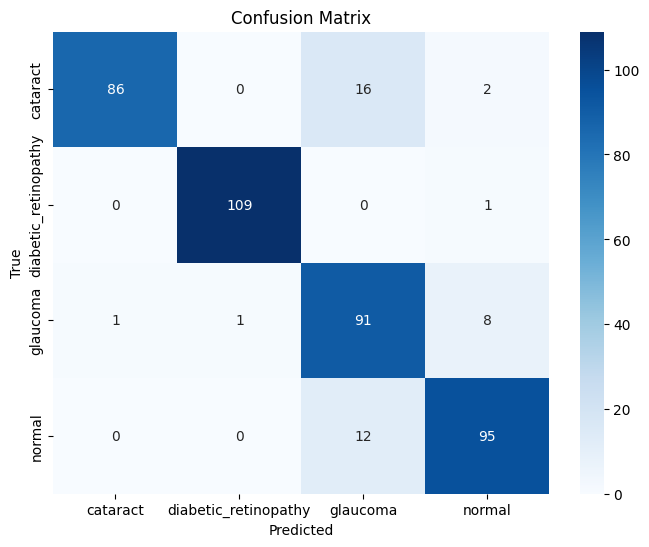

In [ ]:
y_true = test_gen.classes
y_pred = np.argmax(best_model.predict(test_gen), axis=1)
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


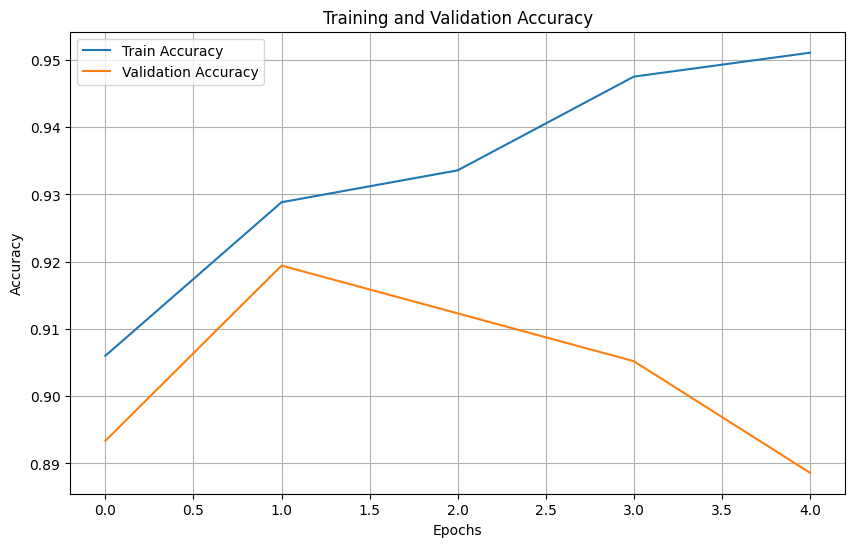

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

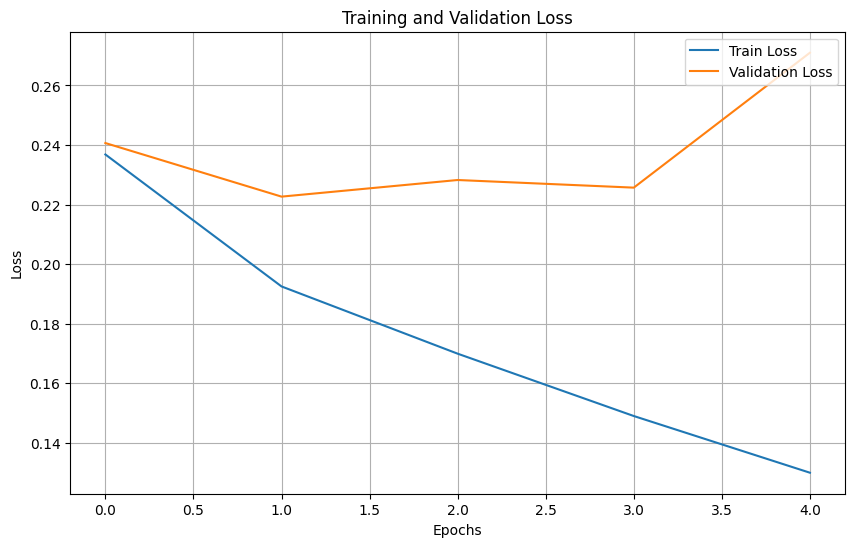

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()